Author: ELLIOT DAHL


## What makes a healthy county? 

I want to explore how nation-wide county health is related to parameters we as a society are in some 
sense control of such as food, access to exercise, education, clinical care, insurance, social network 
and the presence of [Just](https://justcapital.com/2017-rankings/) companies. 

County Health Rankings & Roadmaps in a collaboration between the Robert Wood Johnson Foundation and the University of Wisconsin Population Health Institute gathered data from various sources to try to rank counties in how healthy they are. The data can be found [here](http://www.countyhealthrankings.org/explore-health-rankings/rankings-data). 

The data contains Health Outcomes which is calculated accordingly:
- Length of life (50%)
- Quality of life (50%)

The data also contains Health Factors which is calculated as such: 
- Health behaviours (30%)
- Clinical care (20%)
- Social and Economic Environment (40%)

Health behaviours, Clinical care, Social and Economic Environment is itself calculated from various parameters such as obesity, physical inactivity, primary care physician ratio, high school graduates etc. 

Ideally we would want to be able to say how the health is based on good health factors we have. We want a 1-1 relationship between these. As I show below, it is not. Health Factors is based on human evaulation of how each parameter should play into the Health Outcomes. I intend to find a better relationship using ML classifiers. 

Below is a first attempt at a very simple logistic classifier. 

I also want to incorporate how [Just](https://justcapital.com/) companies are present in the county. 

Moreover, how does the parameters we do not control play into county health, such as political views [data](https://github.com/tonmcg/County_Level_Election_Results_12-16), vicinity to nature, weather etc. I intend to find data on these various aspect and use them as well. 

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## ---------------  Load Data --------------- 

#### Health Data

In [65]:
df_health = pd.read_excel('Data/Health/2017CountyHealthRankingsData.xls',
                          sheetname='Outcomes & Factors Rankings',skiprows=1)
df_health_fact = pd.read_excel('Data/Health/2017CountyHealthRankingsData.xls',
                               sheetname='Ranked Measure Data',skiprows=1)
df_health_fact_add = pd.read_excel('Data/Health/2017CountyHealthRankingsData.xls',
                               sheetname='Additional Measure Data',skiprows=1)

#### Just company Data

In [66]:
df_comp = pd.read_excel('Data/Just/COMPANY_DATA.xlsx')

#### Political Data

In [67]:
df_pol = pd.read_csv('Data/Politics/2016_US_County_Level_Presidential_Results.csv')

##  --------------- Explore data and merge into a data frame ---------------

### Explore health outcome and factor ranking data

Here is a [link](http://www.countyhealthrankings.org/explore-health-rankings/our-methods/calculating-scores-and-ranks) about the ranking

In [68]:
df_health.head()

,FIPS,State,County,# of Ranked Counties,Rank,Quartile,Rank.1,Quartile.1
0,1001,Alabama,Autauga,67,8,1,3,1
1,1003,Alabama,Baldwin,67,2,1,4,1
2,1005,Alabama,Barbour,67,27,2,60,4
3,1007,Alabama,Bibb,67,48,3,37,3
4,1009,Alabama,Blount,67,11,1,21,2


In [69]:
df_health.tail()

,FIPS,State,County,# of Ranked Counties,Rank,Quartile,Rank.1,Quartile.1
3131,56037,Wyoming,Sweetwater,23,17,3,20,4
3132,56039,Wyoming,Teton,23,1,1,1,1
3133,56041,Wyoming,Uinta,23,21,4,17,3
3134,56043,Wyoming,Washakie,23,13,3,15,3
3135,56045,Wyoming,Weston,23,11,2,11,2


In [70]:
df_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 8 columns):
FIPS                    3136 non-null int64
State                   3136 non-null object
County                  3136 non-null object
# of Ranked Counties    3136 non-null int64
Rank                    3136 non-null object
Quartile                3136 non-null object
Rank.1                  3136 non-null object
Quartile.1              3136 non-null object
dtypes: int64(2), object(6)
memory usage: 196.1+ KB


In [71]:
#Not interested in the quartile as of now
df_health = df_health.drop(['# of Ranked Counties','Quartile','Quartile.1'],axis=1)

In [72]:
df_health.head()

,FIPS,State,County,Rank,Rank.1
0,1001,Alabama,Autauga,8,3
1,1003,Alabama,Baldwin,2,4
2,1005,Alabama,Barbour,27,60
3,1007,Alabama,Bibb,48,37
4,1009,Alabama,Blount,11,21


In [73]:
df_health.columns = ['FIPS','State', 'County', 'O Health outcome', 'O Health factors']

In [74]:
df_health.head()

,FIPS,State,County,O Health outcome,O Health factors
0,1001,Alabama,Autauga,8,3
1,1003,Alabama,Baldwin,2,4
2,1005,Alabama,Barbour,27,60
3,1007,Alabama,Bibb,48,37
4,1009,Alabama,Blount,11,21


In [75]:
#Drop non avaliable county data
df_health = df_health[df_health['O Health outcome']!='NR'];

### Explore factor rank health data

In [76]:
df_health_fact.head()

,FIPS,State,County,# Deaths,Years of Potential Life Lost Rate,95% CI - Low,95% CI - High,Quartile,% Fair/Poor,95% CI - Low.1,...,95% CI - High.20,Quartile.33,% Drive Alone - Black,% Drive Alone - Hispanic,% Drive Alone - White,# Workers who Drive Alone,% Long Commute - Drives Alone,95% CI - Low.21,95% CI - High.21,Quartile.34
0,1001,Alabama,Autauga,830.0,9158.2,8251.0,10065.3,1,17.878814,17.309716,...,89.272604,4,NaN,NaN,82.688642,21101,42.6,38.498437,46.701563,3
1,1003,Alabama,Baldwin,2573.0,7393.9,6947.3,7840.4,1,16.361973,15.930774,...,85.889448,2,84.812778,61.239620,85.255443,71535,37.7,35.278607,40.121393,3
2,1005,Alabama,Barbour,413.0,8573.1,7291.9,9854.3,1,25.020401,24.388756,...,85.631456,2,82.056719,NaN,NaN,7090,35.5,30.606183,40.393817,3
3,1007,Alabama,Bibb,407.0,11766.1,10033.8,13498.4,4,19.540231,18.909030,...,88.544332,2,NaN,NaN,88.356941,6778,46.5,39.207540,53.792460,4
4,1009,Alabama,Blount,906.0,9332.8,8429.8,10235.8,2,18.947608,18.348409,...,87.475791,2,NaN,73.117034,82.172461,18624,59.8,55.074426,64.525574,4


In [77]:
df_health_fact_bad = df_health_fact[['FIPS','Years of Potential Life Lost Rate','% Fair/Poor',
                                     'Physically Unhealthy Days','Mentally Unhealthy Days',
                                    '% LBW']]

In [78]:
df_health_fact_bad.head()

,FIPS,Years of Potential Life Lost Rate,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW
0,1001,9158.2,17.878814,4.224031,4.181840,8.789277
1,1003,7393.9,16.361973,3.736320,3.966089,8.630640
2,1005,8573.1,25.020401,4.806057,4.768078,11.669058
3,1007,11766.1,19.540231,4.354390,4.368062,11.968236
4,1009,9332.8,18.947608,4.451573,4.483832,7.348972


In [79]:
df_health_fact_bad.columns = ['FIPS','O prem death','O fair/poor health',
                              'O phys days','O mental days','O lbw']

In [80]:
df_health_fact_bad.head()

,FIPS,O prem death,O fair/poor health,O phys days,O mental days,O lbw
0,1001,9158.2,17.878814,4.224031,4.181840,8.789277
1,1003,7393.9,16.361973,3.736320,3.966089,8.630640
2,1005,8573.1,25.020401,4.806057,4.768078,11.669058
3,1007,11766.1,19.540231,4.354390,4.368062,11.968236
4,1009,9332.8,18.947608,4.451573,4.483832,7.348972


In [81]:
df_health_fact_use = df_health_fact[['FIPS','% Smokers','% Obese','Food Environment Index',
                                    '% Physically Inactive','% With Access','% Excessive Drinking',
                                    '% Alcohol-Impaired','Chlamydia Rate',
                                    'Teen Birth Rate','% Uninsured','PCP Ratio',
                                    'Dentist Ratio','MHP Ratio','Preventable Hosp. Rate',
                                    '% Receiving HbA1c','% Mammography','Graduation Rate',
                                    '% Some College','% Unemployed','% Children in Poverty',
                                    'Income Ratio', '% Single-Parent Households','Association Rate',
                                    'Violent Crime Rate','Injury Death Rate','Average Daily PM2.5',
                                    'Presence of violation','% Severe Housing Problems','% Drive Alone',
                                    '% Long Commute - Drives Alone']]

In [82]:
df_health_fact_use.head()

,FIPS,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,% Excessive Drinking,% Alcohol-Impaired,Chlamydia Rate,Teen Birth Rate,...,Income Ratio,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,Presence of violation,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
0,1001,17.380239,34.1,6.9,28.6,70.821499,14.954122,32.653061,398.2,32.418778,...,4.313549,25.165611,13.719650,265.699747,76.236862,10.8,No,14.723468,87.483416,42.6
1,1003,17.937120,27.4,7.5,22.3,72.168546,15.378031,34.228188,341.1,38.019408,...,4.524768,26.783655,11.543593,216.773078,71.452920,9.6,Yes,14.702872,84.652798,37.7
2,1005,22.776689,44.4,4.9,31.8,45.267145,11.923450,38.461538,613.1,59.021292,...,5.562510,56.455563,8.182393,328.659071,67.521444,10.1,Yes,16.195652,83.766541,35.5
3,1007,19.850766,40.3,7.3,33.9,32.838752,14.309652,33.333333,444.2,47.497880,...,4.272871,29.569672,10.219497,147.290900,81.441875,10.5,No,13.681241,83.186058,46.5
4,1009,21.037382,34.6,8.3,28.0,25.508531,13.902888,20.408163,124.4,43.230404,...,4.037139,27.381214,8.489406,211.598836,96.617688,11.3,No,11.534818,84.866712,59.8


In [83]:
df_health_fact_use.columns = ['FIPS','smokers','obese', 'food env', 'phys inac',
                              'acce excer', 'excess drink', 'alc death', 'std',
                              'teen birth', 'uninsured', 'primary care', 'dentist',
                              'mental provi', 'prev stays', 'diabetes', 'mammo',
                              'high school', 'college', 'unempl','child pove', 'income ineq',
                              'single parent', 'social ass', 'violent crime', 'injury death',
                              'air poll', 'water viol', 'housing prob', 'drv alone','long commute']

In [84]:
df_health_fact_use.head()

,FIPS,smokers,obese,food env,phys inac,acce excer,excess drink,alc death,std,teen birth,...,income ineq,single parent,social ass,violent crime,injury death,air poll,water viol,housing prob,drv alone,long commute
0,1001,17.380239,34.1,6.9,28.6,70.821499,14.954122,32.653061,398.2,32.418778,...,4.313549,25.165611,13.719650,265.699747,76.236862,10.8,No,14.723468,87.483416,42.6
1,1003,17.937120,27.4,7.5,22.3,72.168546,15.378031,34.228188,341.1,38.019408,...,4.524768,26.783655,11.543593,216.773078,71.452920,9.6,Yes,14.702872,84.652798,37.7
2,1005,22.776689,44.4,4.9,31.8,45.267145,11.923450,38.461538,613.1,59.021292,...,5.562510,56.455563,8.182393,328.659071,67.521444,10.1,Yes,16.195652,83.766541,35.5
3,1007,19.850766,40.3,7.3,33.9,32.838752,14.309652,33.333333,444.2,47.497880,...,4.272871,29.569672,10.219497,147.290900,81.441875,10.5,No,13.681241,83.186058,46.5
4,1009,21.037382,34.6,8.3,28.0,25.508531,13.902888,20.408163,124.4,43.230404,...,4.037139,27.381214,8.489406,211.598836,96.617688,11.3,No,11.534818,84.866712,59.8


In [85]:
df_health_fact_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 31 columns):
FIPS             3136 non-null int64
smokers          3136 non-null float64
obese            3136 non-null float64
food env         3136 non-null float64
phys inac        3136 non-null float64
acce excer       3063 non-null float64
excess drink     3136 non-null float64
alc death        3118 non-null float64
std              2986 non-null float64
teen birth       3029 non-null float64
uninsured        3135 non-null float64
primary care     3004 non-null object
dentist          3057 non-null object
mental provi     2849 non-null object
prev stays       3048 non-null float64
diabetes         3095 non-null float64
mammo            3037 non-null float64
high school      2671 non-null float64
college          3136 non-null float64
unempl           3135 non-null float64
child pove       3135 non-null float64
income ineq      3134 non-null float64
single parent    3135 non-null float64
s

### Explore additional health data

In [86]:
df_health_fact_add.head()

,FIPS,State,County,# Deaths,Age-Adjusted Mortality,95% CI - Low,95% CI - High,# Deaths.1,Child Mortality Rate,95% CI - Low.1,...,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,95% CI - Low.13,95% CI - High.13,% Female,# Rural,% Rural
0,1001,Alabama,Autauga,851.0,468.4,436.5,500.2,31.0,55.301841,37.6,...,2.842069,41459,74.907402,338,0.650263,0.251335,1.049190,51.475238,22921,42.002162
1,1003,Alabama,Baldwin,2740.0,361.3,347.2,375.5,84.0,47.728357,38.1,...,4.549627,168996,82.959516,2159,1.169385,0.730252,1.608517,51.260867,77060,42.279099
2,1005,Alabama,Barbour,425.0,439.5,396.5,482.5,15.0,65.780818,36.8,...,4.424478,12340,46.585375,447,1.755971,0.921599,2.590343,46.589150,18613,67.789635
3,1007,Alabama,Bibb,396.0,521.0,468.7,573.2,20.0,104.783360,64.0,...,2.408892,16724,74.055706,76,0.353966,0.000000,0.969253,46.109906,15663,68.352607
4,1009,Alabama,Blount,916.0,445.4,415.5,475.2,24.0,43.877290,28.1,...,8.953930,50403,87.394448,918,1.694821,1.186750,2.202893,50.592132,51562,89.951502


In [87]:
df_health_fact_add.columns

Index(['FIPS', 'State', 'County', '# Deaths', 'Age-Adjusted Mortality',
       '95% CI - Low', '95% CI - High', '# Deaths.1', 'Child Mortality Rate',
       '95% CI - Low.1', '95% CI - High.1', '# Deaths.2',
       'Infant Mortality Rate', '95% CI - Low.2', '95% CI - High.2',
       '% Frequent Physical Distress', '95% CI - Low.3', '95% CI - High.3',
       '% Frequent Mental Distress', '95% CI - Low.4', '95% CI - High.4',
       '% Diabetic', '95% CI - Low.5', '95% CI - High.5', '# HIV Cases',
       'HIV Prevalence Rate', '# Food Insecure', '% Food Insecure',
       '# Limited Access', '% Limited Access', '# Drug Overdose Deaths',
       'Drug Overdose Mortality Rate', '# Motor Vehicle Deaths',
       'MV Mortality Rate', '95% CI - Low.6', '95% CI - High.6',
       '% Insufficient Sleep', '95% CI - Low.7', '95% CI - High.7',
       '# Uninsured', '% Uninsured', '95% CI - Low.8', '95% CI - High.8',
       '# Uninsured.1', '% Uninsured.1', '95% CI - Low.9', '95% CI - High.9',
       'C

In [88]:
df_health_fact_add_use = df_health_fact_add[['FIPS', 'Age-Adjusted Mortality', 'Child Mortality Rate', 
                                            'Infant Mortality Rate','% Frequent Physical Distress',
                                           '% Frequent Mental Distress','% Diabetic','HIV Prevalence Rate',
                                           '% Food Insecure','Drug Overdose Mortality Rate',
                                           'MV Mortality Rate', '% Insufficient Sleep','% Uninsured',
                                            '# Uninsured.1','Costs', 'Other PCP Ratio','% Disconnected Youth',
                                            'Household Income','% Free or Reduced Lunch','Segregation index',
                                            'Segregation Index', 'Homicide Rate', 'Firearm Fatalities Rate',
                                            'Population', '% < 18', '% 65 and over','% African American',
                                            '% American Indian/Alaskan Native','% Asian',
                                             '% Native Hawaiian/Other Pacific Islander','% Hispanic',
                                            '% Non-Hispanic White','% Not Proficient in English','% Female',
                                            '% Rural']]

In [89]:
df_health_fact_add_use.columns = ['FIPS', 'age-adj mort', 'child mort', 'inf mort',
                                 'freq phys stress', 'freq ment strss', 'diab', 'HIV',
                                 'food ins', 'drug over', 'mc deaths', 'insuf sleep',
                                 'unins adu', 'unins kid', 'health cost', 'other primary care',
                                  'dissc youth', 'med income', 'reduc lunch', 'seg black white',
                                 'seg non white white', 'homic', 'firearm', 'population',
                                 '<18','65<','AA', 'native', 'asian', 'islander', 'hispanic',
                                 'non hisp', 'non english', 'female', 'rural'] 

In [90]:
df_health_fact_add_use.head()

,FIPS,age-adj mort,child mort,inf mort,freq phys stress,freq ment strss,diab,HIV,food ins,drug over,...,65<,AA,native,asian,islander,hispanic,non hisp,non english,female,rural
0,1001,468.4,55.301841,6.908463,12.312485,12.568793,13.0,205.0,14.4,9.639251,...,14.311525,18.958570,0.482411,1.199704,0.099373,2.842069,74.907402,0.650263,51.475238,42.002162
1,1003,361.3,47.728357,6.279435,11.627997,12.480731,10.4,169.0,13.7,17.184997,...,19.175392,9.370229,0.738799,0.936139,0.060380,4.549627,82.959516,1.169385,51.260867,42.279099
2,1005,439.5,65.780818,12.053571,15.561980,15.108710,18.4,399.9,23.3,NaN,...,17.161841,47.298879,0.577598,0.445468,0.184982,4.424478,46.585375,1.755971,46.589150,67.789635
3,1007,521.0,104.783360,11.797753,13.211706,13.337571,14.8,120.0,16.4,14.792681,...,15.020148,22.051986,0.425099,0.230262,0.137271,2.408892,74.055706,0.353966,46.109906,68.352607
4,1009,445.4,43.877290,6.360279,13.258619,13.471373,14.1,95.5,12.2,20.777542,...,17.529867,1.711373,0.653685,0.284362,0.110970,8.953930,87.394448,1.694821,50.592132,89.951502


In [91]:
df_health_fact_add_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 35 columns):
FIPS                   3136 non-null int64
age-adj mort           3073 non-null float64
child mort             1943 non-null float64
inf mort               1323 non-null float64
freq phys stress       3136 non-null float64
freq ment strss        3136 non-null float64
diab                   3136 non-null float64
HIV                    2367 non-null float64
food ins               3136 non-null float64
drug over              1625 non-null float64
mc deaths              2709 non-null float64
insuf sleep            3136 non-null float64
unins adu              3135 non-null float64
unins kid              3135 non-null float64
health cost            3134 non-null float64
other primary care     3101 non-null object
dissc youth            2046 non-null float64
med income             3135 non-null float64
reduc lunch            3132 non-null float64
seg black white        2035 non-null floa

### Explore just company data

Only interested in the weight1-column which according to this [link](https://justcapital.com/data-science/) is correlated to Just  company presence in that county.

- Better Just presence in county has larger values

In [92]:
df_comp.head()

,state_county_fips,id,weight1,col1,col3,col4,col5,col6,col7,col8,...,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28
0,1001,0,22,15.58,1.82,12.47,20.199,83770.04,21.25,25.49,...,1.17,0.83,20.199,23534.09,0.61,0.61,9.243,12810.16,0.10,0.10
1,1001,1,125,15.58,13.54,13.57,111.467,510522.29,22.88,25.76,...,1.05,0.95,44.548,51904.70,0.23,0.22,59.035,62194.05,0.35,0.24
2,1001,2,70,15.58,0.00,10.55,66.699,335401.27,11.15,13.45,...,0.58,0.56,24.840,28941.57,0.26,0.15,32.917,45623.42,0.46,0.29
3,1001,3,46,15.58,6.05,9.77,39.944,218625.25,16.18,20.25,...,1.17,0.92,34.205,39854.46,0.65,0.53,11.572,16038.28,0.31,0.15
4,1001,4,7,15.58,0.98,9.72,6.027,20930.97,11.00,15.94,...,1.40,0.83,0.385,448.52,0.31,0.16,3.089,4281.74,0.18,0.14


In [93]:
#sum on FIPS (County code)
df_comp_count = df_comp.groupby('state_county_fips').sum()
df_comp_count.head()

,id,weight1,col1,col3,col4,col5,col6,col7,col8,col9,...,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28
state_county_fips,,,,,,,,,,,,,,,,,,,,,
1001,914,1395,529.72,100.01,389.71,1287.126,6037284.92,496.38,615.60,1287.126,...,34.25,24.39,615.206,716794.36,10.42,8.59,536.527,705735.07,11.42,7.68
1003,3006,10878,1159.50,730.76,893.48,10065.034,45021645.54,1044.98,1317.28,10061.949,...,71.82,49.29,4669.593,5440713.06,19.71,15.64,4101.577,5373149.87,21.80,14.48
1005,683,1261,406.62,74.50,296.72,1179.943,5437307.65,376.09,468.60,1179.688,...,26.02,18.14,584.065,680513.00,7.81,6.77,435.106,594984.27,9.00,5.69
1007,278,582,186.12,32.84,134.06,543.050,2573458.70,175.79,217.27,543.049,...,11.63,8.04,268.289,312590.13,3.02,2.67,178.825,245498.47,3.88,2.49
1009,597,1023,341.22,62.94,249.59,955.548,4395281.78,304.39,381.75,955.548,...,19.89,13.84,470.162,547800.10,6.36,5.39,346.870,469952.96,7.92,5.18


In [94]:
df_comp_count = df_comp_count.reset_index();
df_comp_count = df_comp_count[['state_county_fips','weight1']]

In [95]:
df_comp_count.head()

,state_county_fips,weight1
0,1001,1395
1,1003,10878
2,1005,1261
3,1007,582
4,1009,1023


In [96]:
df_comp_count.columns = ['FIPS','Just']

In [97]:
df_comp_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 2 columns):
FIPS    3004 non-null int64
Just    3004 non-null int64
dtypes: int64(2)
memory usage: 47.0 KB


### Explore political county data

In [98]:
df_pol.head()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060


I will only look at percent democrats and republicans in each county for now

In [99]:
df_pol = df_pol[['per_dem','per_gop','combined_fips']]

In [100]:
df_pol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 3 columns):
per_dem          3141 non-null float64
per_gop          3141 non-null float64
combined_fips    3141 non-null int64
dtypes: float64(2), int64(1)
memory usage: 73.7 KB


In [101]:
df_pol.describe()

,per_dem,per_gop,combined_fips
count,3141.000000,3141.000000,3141.000000
mean,0.317637,0.635144,30388.584527
std,0.152983,0.156130,15162.375610
min,0.031447,0.041221,1001.000000
25%,0.205370,0.545760,18179.000000
50%,0.286400,0.665353,29177.000000
75%,0.398241,0.750265,45081.000000
max,0.928466,0.952727,56045.000000


In [102]:
def pol_view(per_dem,per_gop):
    if per_dem>per_gop:
        return 'Dem'
    else:
        return 'Rep'
    
df_pol['Won'] = df_pol.apply(lambda row: pol_view(row['per_dem'],row['per_gop']), axis=1)

In [103]:
df_pol.head()

,per_dem,per_gop,combined_fips,Won
0,0.377159,0.52887,2013,Rep
1,0.377159,0.52887,2016,Rep
2,0.377159,0.52887,2020,Rep
3,0.377159,0.52887,2050,Rep
4,0.377159,0.52887,2060,Rep


In [104]:
df_pol.tail()

,per_dem,per_gop,combined_fips,Won
3136,0.194046,0.729428,56037,Rep
3137,0.600608,0.321945,56039,Dem
3138,0.149261,0.764187,56041,Rep
3139,0.143203,0.783580,56043,Rep
3140,0.088182,0.869226,56045,Rep


In [105]:
df_pol.rename(columns={'combined_fips':'FIPS'}, inplace=True)

In [106]:
df_pol.columns

Index(['per_dem', 'per_gop', 'FIPS', 'Won'], dtype='object')

In [107]:
df_pol.groupby('Won').count()

,per_dem,per_gop,FIPS
Won,,,
Dem,487,487,487
Rep,2654,2654,2654


###  Merge the data sets

In [108]:
df_one = df_health.merge(df_health_fact_use, how='left', on='FIPS')

In [109]:
df_two = df_one.merge(df_health_fact_bad, how='left', on='FIPS')

In [110]:
df_three = df_two.merge(df_health_fact_add_use, how='left', on='FIPS')

In [111]:
df_four = df_three.merge(df_comp_count, how='left', on='FIPS')

In [112]:
df = df_four.merge(df_pol, how='left', on='FIPS')

In [113]:
df.head()

,FIPS,State,County,O Health outcome,O Health factors,smokers,obese,food env,phys inac,acce excer,...,islander,hispanic,non hisp,non english,female,rural,Just,per_dem,per_gop,Won
0,1001,Alabama,Autauga,8,3,17.380239,34.1,6.9,28.6,70.821499,...,0.099373,2.842069,74.907402,0.650263,51.475238,42.002162,1395.0,0.239569,0.734358,Rep
1,1003,Alabama,Baldwin,2,4,17.937120,27.4,7.5,22.3,72.168546,...,0.060380,4.549627,82.959516,1.169385,51.260867,42.279099,10878.0,0.195653,0.773515,Rep
2,1005,Alabama,Barbour,27,60,22.776689,44.4,4.9,31.8,45.267145,...,0.184982,4.424478,46.585375,1.755971,46.589150,67.789635,1261.0,0.466603,0.522714,Rep
3,1007,Alabama,Bibb,48,37,19.850766,40.3,7.3,33.9,32.838752,...,0.137271,2.408892,74.055706,0.353966,46.109906,68.352607,582.0,0.214220,0.769662,Rep
4,1009,Alabama,Blount,11,21,21.037382,34.6,8.3,28.0,25.508531,...,0.110970,8.953930,87.394448,1.694821,50.592132,89.951502,1023.0,0.084699,0.898519,Rep


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3071 entries, 0 to 3070
Data columns (total 78 columns):
FIPS                   3071 non-null int64
State                  3071 non-null object
County                 3071 non-null object
O Health outcome       3071 non-null object
O Health factors       3071 non-null object
smokers                3071 non-null float64
obese                  3071 non-null float64
food env               3071 non-null float64
phys inac              3071 non-null float64
acce excer             3020 non-null float64
excess drink           3071 non-null float64
alc death              3061 non-null float64
std                    2976 non-null float64
teen birth             3022 non-null float64
uninsured              3071 non-null float64
primary care           2940 non-null object
dentist                2992 non-null object
mental provi           2808 non-null object
prev stays             3031 non-null float64
diabetes               3058 non-null float64
ma

In [115]:
#convert data into int
df['O Health outcome'] = df['O Health outcome'].astype(int);
df['O Health factors'] = df['O Health factors'].astype(int);

 ## --------------- Visually inspect the data ---------------

### Health outcome and health factor ranking

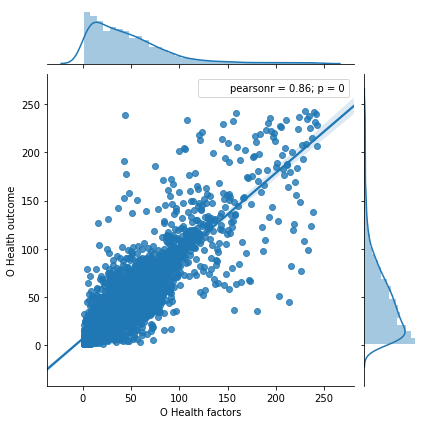

In [116]:
sns.jointplot('O Health factors','O Health outcome', data=df, kind='reg')

#### Obeservation
- There is a strong correlation as expected between the Health factors and the Health outcome
- It is not a direct 1-1 relationship between the two though

### Health outcome and education, rural, income and political view

In [117]:
df_edu = df[['O Health outcome','med income','high school','college','rural','Won']]

Variables

- med income: Median household income
- high school: Percentage of ninth-grade cohort that graduates in four years
- college: Percentage of adults ages 25-44 years with some post-secondary education
- rural: % Rural
- Won: which party won the election 2016

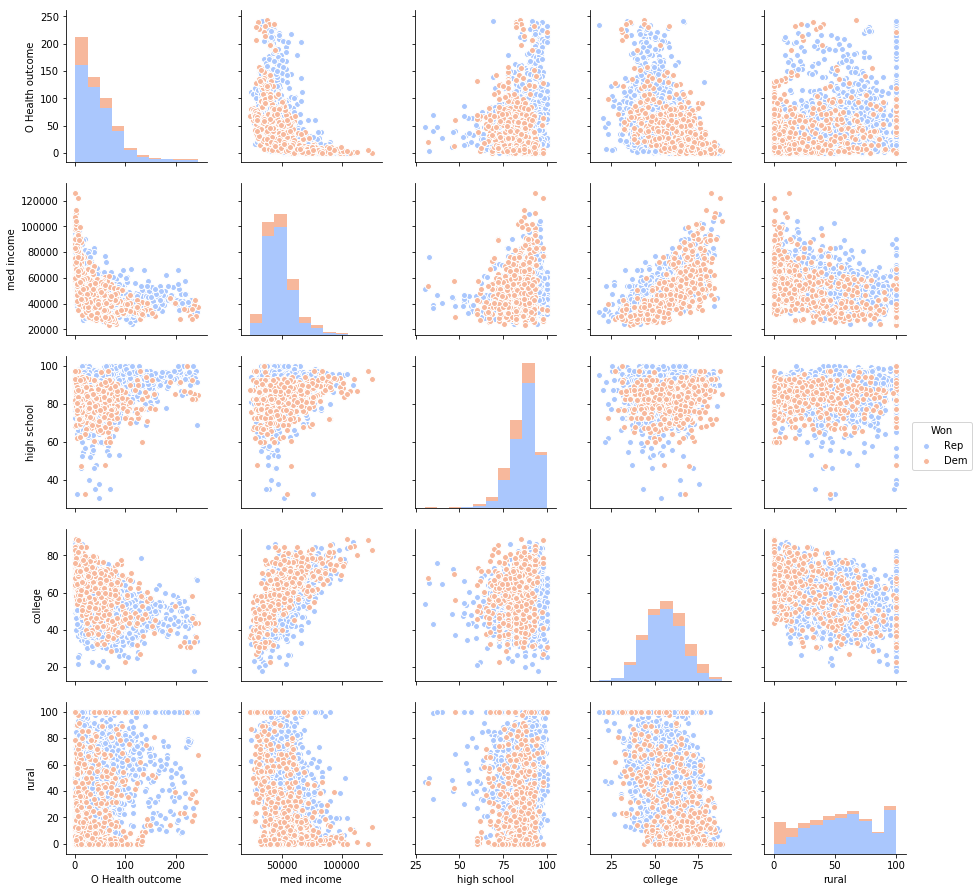

In [118]:
sns.pairplot(df_edu.dropna(),hue='Won',palette='coolwarm')

#### Observations:

Health and variables:

- Having a higher median income in a county makes it healthier, but doesn't increase the standards more after $75,000
- There is a big spread in health outcome although most graduate high school within 4 years
- Highly educated counties, high college rate >80 % , does also make the county have higher health outcome
- Rural areas have a bigger spread in their well being then urban environments

Variable correlations:
- Higher income counties finish high school faster and pursue college
- Finishing high school fast doesn't mean they pursue college 
- Urban environments tend to have a little increase in number of people that pursue college compared with rural 

### Just companies and possible outcomes of bad working environment

In [119]:
df['Just'].describe()

count      2991.000000
mean       3975.088599
std       10780.292311
min           7.000000
25%         243.000000
50%        1062.000000
75%        3048.000000
max      242729.000000
Name: Just, dtype: float64

In [120]:
#look for number of outliers
Q1 = df['Just'].quantile(0.25)
Q3 = df['Just'].quantile(0.75)
IQR = Q3 - Q1
((df['Just'] < (Q1 - 1.5 * IQR)) | 
 (df['Just'] > (Q3 + 1.5 * IQR))).sum()

388

Seems like the Just data has a number of counties that have lots of Just company presence ==> outliers?

Or does it mean that they have not done studies in other counties? 

#### Observations:

- The majority of counties have a poor just company presence
- The Just companies tend to be in urban environments with a large population

- Higher income counties has less mental days and less uninsured adults

- Mental days and insufficient sleep is highly correlated

A few counties have a large presence of Just companies. In order explore this further I drop the Just values over 6000 to perhaps visaully see a better correlation between health outcome and Just company presence. 

#### Obeservation
There is a slight correlation between how many Just companies there are and the health outcome in the specific county

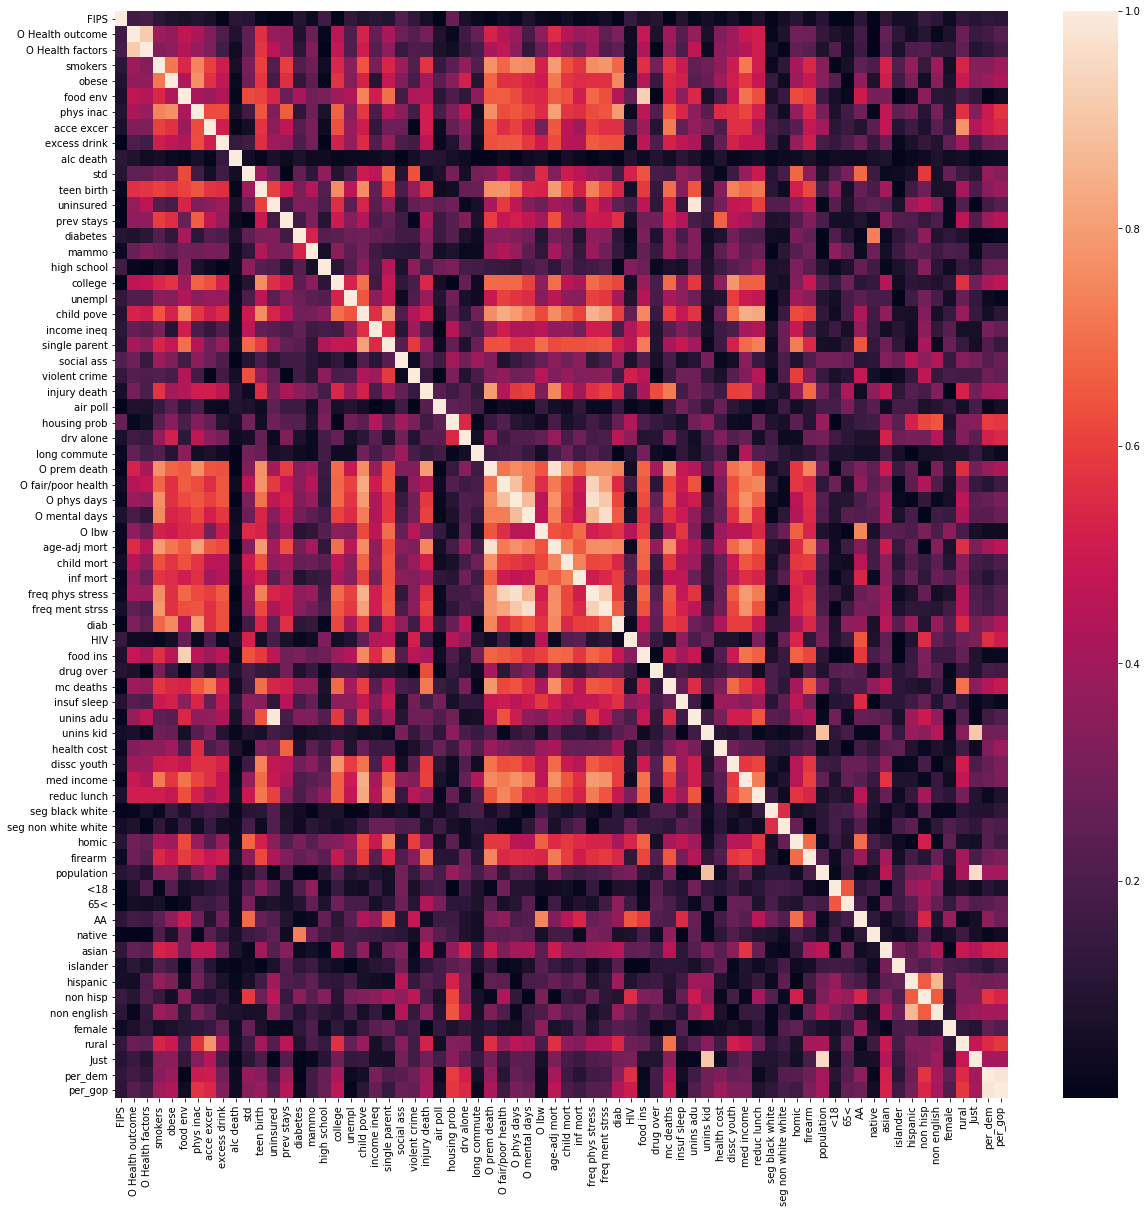

In [121]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(abs(df.dropna().corr()),ax=ax)

### Premature death and 

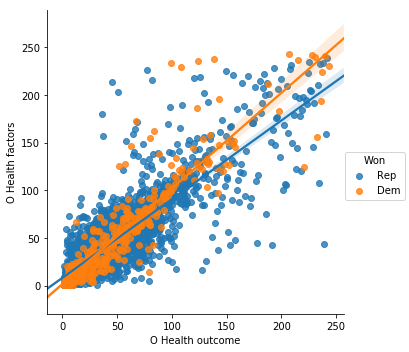

In [123]:
sns.lmplot(x='O Health outcome', y='O Health factors', hue='Won', data=df)

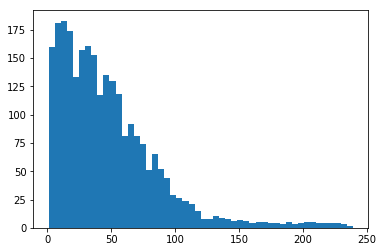

In [125]:
plt.hist(df[df['Won']=='Rep']['O Health factors'],bins=50);

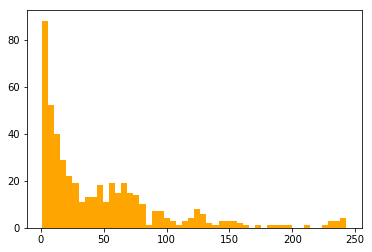

In [127]:
plt.hist(df[df['Won']=='Dem']['O Health factors'],bins=50,color='orange');

## Bulding a logistic regression model

In [128]:
df.head()

,FIPS,State,County,O Health outcome,O Health factors,smokers,obese,food env,phys inac,acce excer,...,islander,hispanic,non hisp,non english,female,rural,Just,per_dem,per_gop,Won
0,1001,Alabama,Autauga,8,3,17.380239,34.1,6.9,28.6,70.821499,...,0.099373,2.842069,74.907402,0.650263,51.475238,42.002162,1395.0,0.239569,0.734358,Rep
1,1003,Alabama,Baldwin,2,4,17.937120,27.4,7.5,22.3,72.168546,...,0.060380,4.549627,82.959516,1.169385,51.260867,42.279099,10878.0,0.195653,0.773515,Rep
2,1005,Alabama,Barbour,27,60,22.776689,44.4,4.9,31.8,45.267145,...,0.184982,4.424478,46.585375,1.755971,46.589150,67.789635,1261.0,0.466603,0.522714,Rep
3,1007,Alabama,Bibb,48,37,19.850766,40.3,7.3,33.9,32.838752,...,0.137271,2.408892,74.055706,0.353966,46.109906,68.352607,582.0,0.214220,0.769662,Rep
4,1009,Alabama,Blount,11,21,21.037382,34.6,8.3,28.0,25.508531,...,0.110970,8.953930,87.394448,1.694821,50.592132,89.951502,1023.0,0.084699,0.898519,Rep


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3071 entries, 0 to 3070
Data columns (total 78 columns):
FIPS                   3071 non-null int64
State                  3071 non-null object
County                 3071 non-null object
O Health outcome       3071 non-null int64
O Health factors       3071 non-null int64
smokers                3071 non-null float64
obese                  3071 non-null float64
food env               3071 non-null float64
phys inac              3071 non-null float64
acce excer             3020 non-null float64
excess drink           3071 non-null float64
alc death              3061 non-null float64
std                    2976 non-null float64
teen birth             3022 non-null float64
uninsured              3071 non-null float64
primary care           2940 non-null object
dentist                2992 non-null object
mental provi           2808 non-null object
prev stays             3031 non-null float64
diabetes               3058 non-null float64
mamm

In [130]:
df_train = df.dropna() #Just for now, will see if I can do interpolataion later
X = df_train.drop(['FIPS','State','County','O Health outcome','O Health factors','Won',
                  'primary care','dentist','mental provi','water viol','other primary care'],axis=1)
#Later I will make some object type parameters integers or float to include in prediction
y = df_train['O Health outcome'].astype(int)

In [131]:
from sklearn import preprocessing

In [132]:
X_scaled = preprocessing.scale(X)

## Train Test Split

In [133]:
from sklearn.model_selection import train_test_split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=10)

## Training and Predicting

In [135]:
from sklearn.linear_model import LogisticRegression

In [136]:
logmodel = LogisticRegression(C=0.01)
logmodel.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
Pred_train = logmodel.predict(X_train)

In [138]:
predictions = logmodel.predict(X_test)

## Evaluation

In [139]:
from sklearn.metrics import classification_report

In [140]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          1       0.15      0.50      0.23         6
          2       0.02      0.33      0.04         3
          3       0.00      0.00      0.00         3
          4       0.00      0.00      0.00         4
          5       0.00      0.00      0.00         9
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         9
          8       0.00      0.00      0.00         5
          9       0.00      0.00      0.00         8
         10       0.00      0.00      0.00         3
         11       0.00      0.00      0.00         5
         12       0.09      0.20      0.13         5
         13       0.00      0.00      0.00         7
         14       0.00      0.00      0.00         6
         15       0.00      0.00      0.00         5
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00         4
         18       0.00      0.00      0.00   

/Users/elliotdahl/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/elliotdahl/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [141]:
from sklearn.metrics import accuracy_score

In [142]:
accuracy_score(df['O Health outcome'], df['O Health factors'])

0.065450993161836529

In [143]:
accuracy_score(Pred_train, y_train)

0.27962085308056872

In [144]:
accuracy_score(predictions,y_test)

0.022058823529411766

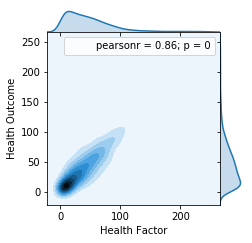

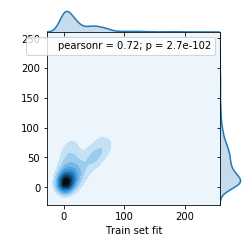

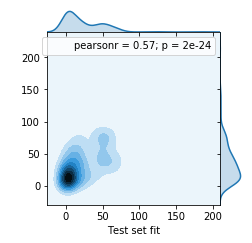

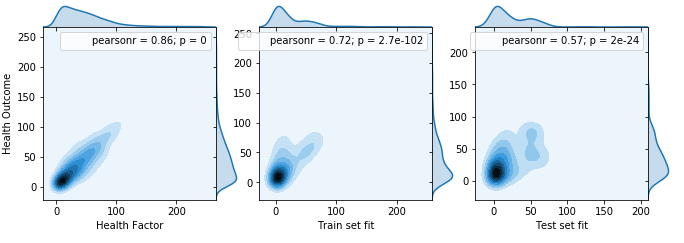

In [145]:
JG1 = sns.jointplot('O Health factors','O Health outcome', data=df, kind='kde');
JG2 = sns.jointplot(Pred_train, y_train, kind='kde');
JG3 = sns.jointplot(predictions,y_test,kind='kde')

#subplots migration
f = plt.figure();
for J in [JG1, JG2, JG3]:
    for A in J.fig.axes:
        f._axstack.add(f._make_key(A), A);

#subplots size adjustment
f.axes[0].set_position([0.1, 0.1, 0.4,  0.4]);
f.axes[1].set_position([0.1, 0.50, 0.4,  0.05]);
f.axes[2].set_position([0.50, 0.1, 0.05, 0.4]);

f.axes[0].set_ylabel('Health Outcome')
f.axes[0].set_xlabel('Health Factor')

f.axes[3].set_position([0.60, 0.1, 0.4,  0.4]);
f.axes[4].set_position([0.60, 0.50, 0.4,  0.05]);
f.axes[5].set_position([1.0, 0.1, 0.05, 0.4]);

f.axes[3].set_ylabel(' ')
f.axes[3].set_xlabel('Train set fit')

f.axes[6].set_position([1.10, 0.1, 0.4,  0.4]);
f.axes[7].set_position([1.10, 0.50, 0.4,  0.05]);
f.axes[8].set_position([1.50, 0.1, 0.05, 0.4]);

f.axes[6].set_ylabel(' ')
f.axes[6].set_xlabel('Test set fit')

f.savefig('Compare_log_reg.pdf', bbox_inches='tight')


## Observation, linear model might not be the best predictor in the following case 